## Let's dive into our model's predictions for stage 1

**Questions to ask:**
  - Which games did it get wrong?
  - What do those games have in common?
  - Would including those features be risking "overfitting" to these few years (2015-2019)?

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

plt.style.use('fivethirtyeight')

os.chdir("../../data/women")

In [2]:
## Provided files
teams = pd.read_csv("WTeams.csv")
seeds = pd.read_csv("WNCAATourneySeeds.csv")
tourney_results = pd.read_csv("WNCAATourneyCompactResults.csv")
teams_and_seeds = teams.merge(seeds)

## Our submission
submission = pd.read_csv("subs/submission_probs_full_2021-03-07.csv")

## Create matching ID on tourney_results
tourney_results['ID'] = tourney_results.apply(lambda x: f"{x['Season']}_{x['WTeamID']}_{x['LTeamID']}"
                                              if x['WTeamID'] < x['LTeamID']
                                              else f"{x['Season']}_{x['LTeamID']}_{x['WTeamID']}", axis=1)
## Create binary target
tourney_results['Team1_Win'] = tourney_results.apply(lambda x: 1 if x['WTeamID'] < x['LTeamID'] else 0, axis=1)

## Merge with predictions and calculate a residual
tourney_results = tourney_results.merge(submission)
tourney_results['residual'] = tourney_results['Team1_Win'] - tourney_results['Pred']
tourney_results['abs_residual'] = np.abs(tourney_results['residual'])

## Merge in team names and seeds
teams_and_seeds = teams_and_seeds.rename(columns = {'TeamName': 'WTeamName',
                                                    'Seed': 'WSeed',
                                                    'TeamID': 'WTeamID'})
tourney_results = tourney_results.merge(teams_and_seeds)
teams_and_seeds = teams_and_seeds.rename(columns = {'WTeamName': 'LTeamName',
                                                    'WSeed': 'LSeed',
                                                    'WTeamID': 'LTeamID'})
tourney_results = tourney_results.merge(teams_and_seeds)

In [3]:
## Change 1/2 variables into W/L
tourney_results['W_lower_higher_avg'] = tourney_results.apply(lambda x: x['lower_higher_avg_1'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['lower_higher_avg_2'], axis=1)
tourney_results['L_lower_higher_avg'] = tourney_results.apply(lambda x: x['lower_higher_avg_2'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['lower_higher_avg_1'], axis=1)
tourney_results['WConfAbbrev'] = tourney_results.apply(lambda x: x['ConfAbbrev_1'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['ConfAbbrev_2'], axis=1)
tourney_results['LConfAbbrev'] = tourney_results.apply(lambda x: x['ConfAbbrev_2'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['ConfAbbrev_1'], axis=1)
tourney_results['W_rank_in_conf'] = tourney_results.apply(lambda x: x['rank_in_conf_1'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['rank_in_conf_2'], axis=1)
tourney_results['L_rank_in_conf'] = tourney_results.apply(lambda x: x['rank_in_conf_2'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['rank_in_conf_1'], axis=1)
tourney_results['W_od_margin'] = tourney_results.apply(lambda x: x['od_margin_1'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['od_margin_2'], axis=1)
tourney_results['L_od_margin'] = tourney_results.apply(lambda x: x['od_margin_2'] 
                                                              if x['WTeamID'] < x['LTeamID']
                                                              else x['od_margin_1'], axis=1)


### Biggest misclassifications

Which games were we most confident in that ended up being the biggest upsets according to our model?

In [4]:
tourney_results[['Season', 'WTeamName', 'LTeamName', 'WScore', 'LScore', 'WSeed', 'LSeed',
                 'lower_higher_avg_diff', 'W_lower_higher_avg', 'L_lower_higher_avg', 
                 'WConfAbbrev', 'W_rank_in_conf', 'LConfAbbrev', 'L_rank_in_conf',
                 'delta_od_margin', 'W_od_margin', 'L_od_margin', 'residual',
                 'abs_residual']].sort_values('abs_residual', ascending = False).head(20)

,Season,WTeamName,LTeamName,WScore,LScore,WSeed,LSeed,lower_higher_avg_diff,W_lower_higher_avg,L_lower_higher_avg,WConfAbbrev,W_rank_in_conf,LConfAbbrev,L_rank_in_conf,delta_od_margin,W_od_margin,L_od_margin,residual,abs_residual
454,2017,Oregon,Maryland,77,63,W10,W03,3.8,0.0,3.8,NaN,NaN,big_ten,1.0,24.671364,8.866283,33.537647,-0.983185,0.983185
455,2017,Oregon,Maryland,77,63,W10,W03,3.8,0.0,3.8,NaN,NaN,NaN,NaN,24.671364,8.866283,33.537647,-0.983185,0.983185
309,2016,Washington,Maryland,74,65,Y07,Y02,3.2,0.6,3.8,pac_twelve,5.0,NaN,NaN,20.341504,11.876918,32.218422,-0.967472,0.967472
310,2016,Washington,Maryland,74,65,Y07,Y02,3.2,0.6,3.8,NaN,NaN,NaN,NaN,20.341504,11.876918,32.218422,-0.967472,0.967472
308,2016,Washington,Maryland,74,65,Y07,Y02,3.2,0.6,3.8,NaN,NaN,big_ten,1.0,20.341504,11.876918,32.218422,-0.967472,0.967472
307,2016,Washington,Maryland,74,65,Y07,Y02,3.2,0.6,3.8,pac_twelve,5.0,big_ten,1.0,20.341504,11.876918,32.218422,-0.967472,0.967472
365,2017,Mississippi St,Connecticut,66,64,X02,W01,3.0,3.6,6.6,NaN,NaN,NaN,NaN,18.740885,27.208653,45.949539,-0.959111,0.959111
364,2017,Mississippi St,Connecticut,66,64,X02,W01,3.0,3.6,6.6,sec,2.0,NaN,NaN,18.740885,27.208653,45.949539,-0.959111,0.959111
363,2017,Mississippi St,Connecticut,66,64,X02,W01,3.0,3.6,6.6,NaN,NaN,aac,1.0,18.740885,27.208653,45.949539,-0.959111,0.959111
362,2017,Mississippi St,Connecticut,66,64,X02,W01,3.0,3.6,6.6,sec,2.0,aac,1.0,18.740885,27.208653,45.949539,-0.959111,0.959111


Observations:
 - Interestingly, Maryland was upset by pretty large margins in 2016 and 2017 in early rounds.  Maybe this is a sign that the Big 10 is overrated by our model?
 - The predictions are super aggressive for 1 seeds against other 1 seeds or 2 seeds.

### Do we need to "trim" our predictions to minimize log-loss?

See this [this notebook](https://www.kaggle.com/luisgarcia/should-you-have-trimmed-your-predictions-probably) for an overview of why it can be beneficial to trim confident predictions under the log-loss evaluation metric.

From the notebook:

    We search for  α  in the interval  [0,1/4]  to find the ideal  α . The function trimmed_loss(alpha) computes the log loss of the trimmed predictions against the truth. The minimum value is labeled in the plot and we see that some amount of trim would have benefited me in this competition, but too much trim is detrimental. The amount we shave off is actually minimal, but this can still lead to big movements on the leaderboard.

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

os.chdir("../../data/women")

## Results
tourney_results = pd.read_csv("WNCAATourneyCompactResults.csv")

## Our submission
submission = pd.read_csv("subs/submission_probs_2021-03-07.csv")

## Create matching ID on tourney_results
tourney_results['ID'] = tourney_results.apply(lambda x: f"{x['Season']}_{x['WTeamID']}_{x['LTeamID']}"
                                              if x['WTeamID'] < x['LTeamID']
                                              else f"{x['Season']}_{x['LTeamID']}_{x['WTeamID']}", axis=1)
## Create binary target
tourney_results['Team1_Win'] = tourney_results.apply(lambda x: 1 if x['WTeamID'] < x['LTeamID'] else 0, axis=1)

## Merge with predictions and calculate a residual
tourney_results = tourney_results.merge(submission)
tourney_results['residual'] = tourney_results['Team1_Win'] - tourney_results['Pred']
tourney_results['abs_residual'] = np.abs(tourney_results['residual'])

In [10]:
def trim_pred(x, alpha):
    upper = 1-alpha
    lower = alpha
    if x > upper:
        return upper
    if x < lower:
        return lower
    else: return x
    
def trimmed_loss(alpha):
    trimmed_preds = [trim_pred(x,alpha) for x in tourney_results.Pred]
    return log_loss(tourney_results.Team1_Win , trimmed_preds)

def annot_min(x,y, ax=None):
    minIxVal = np.argmin(y);
    zeroBasedIx = y[minIxVal];
    xmin = x[minIxVal];
    ymin = y[minIxVal]
    text = "Minimum: Trim Interval = [{}, {}], Log Loss = {}".format(round(xmin,2), round(1-xmin,2), round(ymin, 3))
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.1")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.90), **kw)


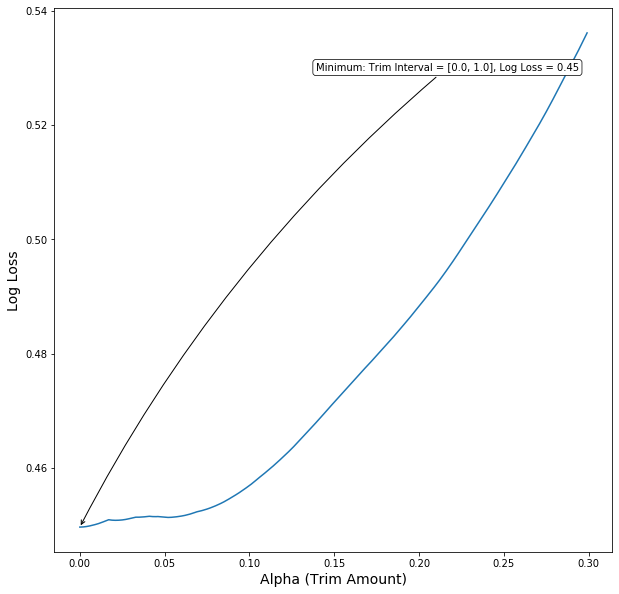

In [11]:
xvals = np.arange(0, .30, 0.001)
yvals = [trimmed_loss(alpha) for alpha in xvals]

plt.figure(figsize=(10,10))
plt.plot(xvals, yvals)
plt.xlabel('Alpha (Trim Amount)', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
annot_min(list(xvals),yvals, ax=None)
plt.show()

As it stands, our model would not benefit from "trimming" predictions in the 2015-2019 tournaments.  

Note that these tournaments did not have any major upsets, but it may also be likely that the women's tournament is less likely than the men's to see major upsets. Still, we may want to consider it to avoid catastrophe if there is a big upset.